# 라이브러리 목록

In [ ]:
# 표준 라이브러리
import os
import gc
import random
import concurrent
from collections import defaultdict
from copy import deepcopy

# 서드파티 라이브러리
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2M, NASNetLarge, nasnet
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping

# 클래스

## 전이학습 모델

In [ ]:
class PretrainedModel(keras.Model):
    def __init__(self, *, base_model, unfreeze_num, scale, offset, units, rate, classes, rotation, zoom, factor):
        super().__init__()
        self.base_model = base_model
        self.augmentation = keras.Sequential([
                                                layers.RandomRotation(rotation),
                                                layers.RandomZoom(zoom),
                                                layers.RandomBrightness(factor=factor)
                                              ])
        self.scaling = layers.Rescaling(scale=scale, offset=offset)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(units=units)
        self.drop_out = layers.Dropout(rate=rate)
        self.final = layers.Dense(units=classes, activation="softmax")

        for model_layer in self.base_model.layers[:-unfreeze_num]:
            model_layer.trainable = False
        for model_layer in self.base_model.layers[-unfreeze_num:]:
            # 배치 정규화 또는 층 정규화 층은 제외시키기
            if isinstance(model_layer, layers.BatchNormalization) or isinstance(model_layer, layers.LayerNormalization):
                model_layer.trainable = False
            else:
                model_layer.trainable = True

    def build(self, input_shape):
        self.augmentation.build(input_shape)
        input_shape = self.augmentation.compute_output_shape(input_shape)
        self.scaling.build(input_shape)
        input_shape = self.scaling.compute_output_shape(input_shape)
        self.base_model.build(input_shape)
        input_shape = self.base_model.compute_output_shape(input_shape)
        self.flatten.build(input_shape)
        input_shape = self.flatten.compute_output_shape(input_shape)
        self.dense.build(input_shape)
        input_shape = self.dense.compute_output_shape(input_shape)
        self.drop_out.build(input_shape)
        input_shape = self.drop_out.compute_output_shape(input_shape)
        self.final.build(input_shape)
        self.built = True

    def call(self, inputs, training=True):
        if training:
            inputs = self.augmentation(inputs)

        x = self.scaling(inputs)
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.drop_out(x)
        x = self.final(x)

        return x

## 앙상블 분류기

In [ ]:
class EnsembleClassifier(tf.Module):
    def __init__(self, model1, model2, proba_weights):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.proba_weights = proba_weights

    def __call__(self, inputs):
        model1_output = self.model1(inputs, training=False)
        model2_output = self.model2(inputs, training=False)
        probas = model1_output * self.proba_weights[0] + model2_output * self.proba_weights[1]
        result = tf.math.argmax(input=probas, axis=-1)

        return result

# 함수

In [ ]:
# 경로에 있는 이미지 파일을 불러오기
def get_image(label: str, file_lst: list[str]) -> tuple[str, list[tf.Tensor]]:
    """경로에 있는 이미지를 불러오는 함수

    Args:
        label: 불러올 이미지의 레이블명
        file_lst: 이미지 파일 경로 리스트

    Returns:
        (레이블명, 이미지 텐서)
    """

    img = map(lambda x: data_path + f"/{label}/{x}", file_lst)
    img = map(lambda x: tf.io.read_file(x), img)
    img = map(lambda x: tf.image.decode_image(x), img)
    return label, list(img)


# 이미지 증식 함수
def image_trans_func(image: tf.Tensor, layer: layers.Layer) -> tf.Tensor:
    """이미지를 증식시키는 함수

    Args:
        image: 원본 이미지
        layer: 증식 레이어

    Returns:
        증식 레이어를 거쳐 변환된 이미지
    """

    image_trans = layer(image)
    image_trans = tf.cast(image_trans, dtype=tf.uint8)
    return image_trans


# 데이터셋 생성 함수
def make_dataset(x, y, batch_size: int) -> tf.data.Dataset:
    """tf.data.Dataset을 생성하는 함수

    Args:
        x: 입력 데이터
        y: 레이블 데이터
        batch_size: 배치 사이즈 크기

    Returns:
        tf.data.Dataset
    """

    dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(len(x))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset


# 학습/검증 데이터셋 생성 함수
def make_train_valid_dataset(images, labels, rate=0.1, batch_size=32, SEED=None) -> tuple[tf.data.Dataset, tf.data.Dataset]:
    """학습/검증 데이터셋을 생성하는 함수

    Args:
        train_images: 이미지 array
        train_labels: 레이블 array
        rate: 검증 데이터 비율
        batch_size: 배치 사이즈 크기
        SEED: train / valid 나눌 때의 랜덤 시드

    Returns:
        (학습 데이터셋, 검증 데이터셋)
    """

    assert len(images) == len(labels)
    assert 0 < rate < 1
    assert batch_size > 0

    train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=rate,
                                                                              random_state=SEED, shuffle=True, stratify=labels)

    train_dataset = make_dataset(x=train_images, y=train_labels, batch_size=batch_size)
    valid_dataset = make_dataset(x=valid_images, y=valid_labels, batch_size=batch_size)

    return train_dataset, valid_dataset

# 변수

In [ ]:
# 랜덤 시드 설정
SEED = 1234
tf.random.set_seed(SEED)

# 1. 데이터 확인하기

In [ ]:
# 이미지 폴더 가져오기
data_path = "./drive/MyDrive/Practice/Computer_Vision/train" # 디렉터리 경로
class_list = os.listdir(data_path) # 클래스의 레이블 리스트
data_dict = {} # 각 레이블 폴더 내 파일 리스트 딕셔너리

for label in class_list:
    label_path = data_path + "/" + label # 클래스내 각 레이블 경로
    file_list = os.listdir(label_path) # 레이블 폴더 내 이미지 파일 이름 리스트
    data_dict[label] = file_list

## - 클래스의 레이블 분포 확인

In [ ]:
# 레이블 분포 확인
print("레이블 내 데이터 갯수")
for label, f in data_dict.items():
    print(f"{label}: {len(f)}개")

레이블 내 데이터 갯수
horse: 151개
person: 399개
house: 245개
dog: 329개
giraffe: 235개
guitar: 134개
elephant: 205개


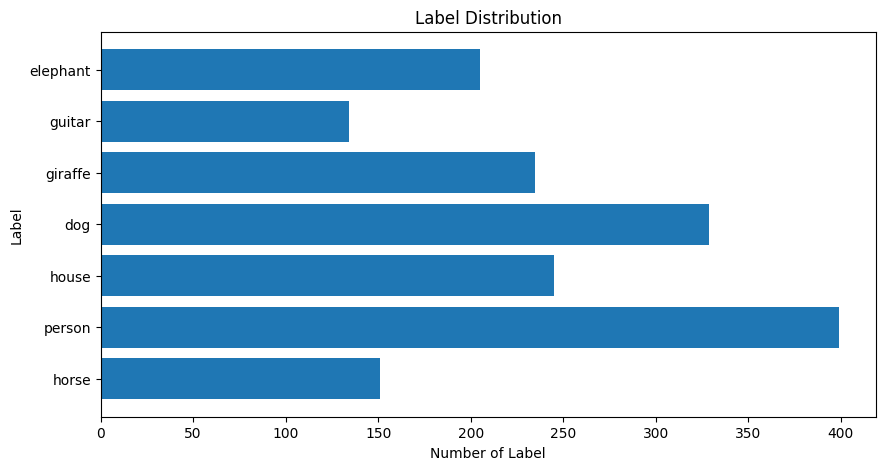

In [ ]:
# 레이블 분포 시각화
label_list = [] # 레이블 리스트
label_count_list = [] # 레이블 내 이미지 파일 갯수 리스트

for label, f_list in data_dict.items():
    label_list.append(label)
    n = len(f_list)
    label_count_list.append(n)

fig = plt.figure(figsize=(10, 5))

plt.barh(label_list, label_count_list)
plt.xlabel("Number of Label")
plt.ylabel("Label")
plt.title("Label Distribution")
plt.show()

# 2. 데이터 불러오기

In [ ]:
image_dict = defaultdict(list)

with concurrent.futures.ThreadPoolExecutor(max_workers=len(data_dict)) as executor:
    future_to_image = {executor.submit(get_image, label, file_lst): (label, file_lst) for label, file_lst in data_dict.items()}
    for future in concurrent.futures.as_completed(future_to_image):
        label, images_list = future.result()
        image_dict[label].extend(images_list)

## - 이미지 크기 확인하기

In [ ]:
for label in image_dict:
    shape_ = set(map(lambda x: x.shape, image_dict[label]))
    print(f"{label}의 shape: {shape_}")

horse의 shape: {TensorShape([227, 227, 3])}
guitar의 shape: {TensorShape([227, 227, 3])}
elephant의 shape: {TensorShape([227, 227, 3])}
giraffe의 shape: {TensorShape([227, 227, 3])}
house의 shape: {TensorShape([227, 227, 3])}
dog의 shape: {TensorShape([227, 227, 3])}
person의 shape: {TensorShape([227, 227, 3])}


## - 이미지 데이터 증식을 통한 클래스 내 불균형 해결

In [ ]:
max_count = 500

In [ ]:
success_image = [] # 이미지 증식 성공 데이터 리스트
fail_image = [] # 이미지 증식 실패 데이터 리스트

In [ ]:
# 이미지 무작위 회전 또는 확대/축소 데이터 추가
rotation = 0.5
zoom = 0.15
factor = 0.35

augmentation_layer = keras.Sequential([
                                        layers.RandomRotation(rotation),
                                        layers.RandomZoom(zoom),
                                        layers.RandomBrightness(factor=factor)
                                      ])

for label, image_list in image_dict.items():
    origin_image_list = deepcopy(image_list)
    duplication_check_set = set(map(lambda x: tuple(x.numpy().flatten()), origin_image_list)) # 중복 확인용 집합

    while len(image_dict[label]) < max_count:
        image = random.choice(origin_image_list)
        augmentation_image = image_trans_func(image=image, layer=augmentation_layer)

        # 이미지 증식 확인 및 중복여부 확인
        duplication_check = tuple(augmentation_image.numpy().flatten())
        if duplication_check not in duplication_check_set:
            image_dict[label].append(augmentation_image)
            success_image.append((image, augmentation_image))
            duplication_check_set.add(duplication_check)
        else:
            fail_image.append((image, augmentation_image))

In [ ]:
print(f"성공한 데이터 갯수: {len(success_image)}")
print(f"실패한 데이터 갯수: {len(fail_image)}")

성공한 데이터 갯수: 1802
실패한 데이터 갯수: 0


In [ ]:
# 증식 실패한 이미지들
if len(fail_image) > 0:
    for i in range(0, len(fail_image), 2):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(fail_image[i][0])
        plt.axis("off")
        ax = plt.subplot(4, 4, i + 2)
        plt.imshow(fail_image[i][1])
        plt.axis("off")

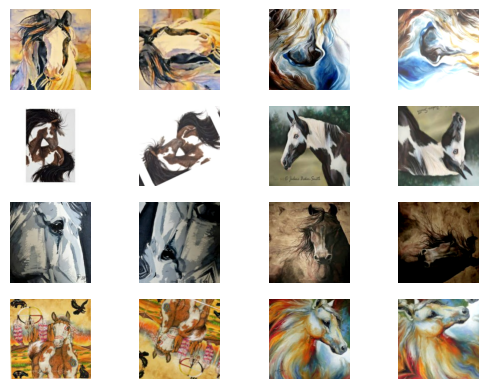

In [ ]:
# 증식 성공한 이미지들
if len(success_image) > 0:
    for i in range(0, 16, 2):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(success_image[i][0])
        plt.axis("off")
        ax = plt.subplot(4, 4, i + 2)
        plt.imshow(success_image[i][1])
        plt.axis("off")

In [ ]:
del augmentation_layer
del success_image
del fail_image
del origin_image_list
del duplication_check_set

gc.collect()

0

In [ ]:
# 레이블 분포 확인
print("레이블 내 증가한 데이터 갯수")
print("")
for label in data_dict.keys():
    print(f"{label}: {len(data_dict[label])}개 -> {len(image_dict[label])}개")

레이블 내 증가한 데이터 갯수

horse: 151개 -> 500개
person: 399개 -> 500개
house: 245개 -> 500개
dog: 329개 -> 500개
giraffe: 235개 -> 500개
guitar: 134개 -> 500개
elephant: 205개 -> 500개


# 훈련 데이터 만들기

In [ ]:
# 하이퍼 파라미터
rate = 0.1
batch_size = 16

In [ ]:
image_list = []
label_list = []

for label, images in image_dict.items():
    n = len(images)
    image_list.extend(images)
    label_list.extend([label] * n)

In [ ]:
# 훈련 데이터의 입력 데이터
train_images = np.array(image_list, dtype=np.uint8)
data_count = len(train_images)
data_count

3500

In [ ]:
# 훈련 데이터의 라벨 데이터
label_dict = {label: idx for idx, label in enumerate(image_dict.keys())}
train_labels = np.array(list(map(lambda x: label_dict[x], label_list)))

In [ ]:
# 클래스 내 레이블 갯수
class_count = len(image_dict)
class_count

7

In [ ]:
train_dataset, valid_dataset = make_train_valid_dataset(images=train_images, labels=train_labels,
                                                        rate=rate, batch_size=batch_size, SEED=SEED)

In [ ]:
del image_list
del label_list
del train_images
del train_labels
del class_list
del data_dict
del image_dict
del label_dict

gc.collect()

618

# 데이터 훈련

In [ ]:
# 하이퍼 파라미터
epochs = 50

## 모델

In [ ]:
input_shape = (227, 227, 3)
eff_model = EfficientNetV2M(weights="imagenet", include_top=False, input_shape=input_shape, include_preprocessing=False)
nas_model = NASNetLarge(weights="imagenet", include_top=False, input_shape=input_shape)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
eff_model.summary()

In [ ]:
nas_model.summary()

In [ ]:
unfreeze_num = 10
units = 256
rate = 0.5
classes = class_count
rotation = rotation
zoom = zoom
factor = factor

model1 = PretrainedModel(base_model=eff_model, unfreeze_num=unfreeze_num, scale=1./127.5, offset=-1,
                         units=units, rate=rate, classes=classes,
                         rotation=rotation, zoom=zoom, factor=factor)
model2 = PretrainedModel(base_model=nas_model, unfreeze_num=unfreeze_num, scale=1./127.5, offset=-1,
                         units=units, rate=rate, classes=classes,
                         rotation=rotation, zoom=zoom, factor=factor)

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer=Nadam(learning_rate=1e-5), metrics=["accuracy"])
model2.compile(loss="sparse_categorical_crossentropy", optimizer=Nadam(learning_rate=1e-5), metrics=["accuracy"])

monitor = "val_loss"
min_delta = 1e-4
patience = 15

In [ ]:
callbacks = [
              EarlyStopping(monitor=monitor, min_delta=min_delta,
                            patience=patience, restore_best_weights=True)
            ]

history1 = model1.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, shuffle=True, callbacks=callbacks)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.3117 - loss: 2.0567 - val_accuracy: 0.7886 - val_loss: 0.6099
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 66s 190ms/step - accuracy: 0.6714 - loss: 1.0033 - val_accuracy: 0.8429 - val_loss: 0.4363
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.7367 - loss: 0.7994 - val_accuracy: 0.8514 - val_loss: 0.3889
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.7544 - loss: 0.7149 - val_accuracy: 0.8743 - val_loss: 0.3702
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.7805 - loss: 0.6691 - val_accuracy: 0.8829 - val_loss: 0.3485
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 190ms/step - accuracy: 0.8023 - loss: 0.6051 - val_accuracy: 0.8971 - val_loss: 0.3161
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.8053 - loss: 0.5787 - val_accuracy: 0.8971 - val_loss: 0.2841
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 40s 187ms/step - accuracy: 0.8282 - loss: 0

In [ ]:
model1.summary()

Model: "pretrained_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-m (Functional)        │ (None, 8, 8, 1280)          │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 81920)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      20,971,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,106,828 (465.80 MB)

 Trainable params: 23,991,431 (91.52 MB)

 Non-trainable params: 50,132,532 (191.24 MB)

 Optimizer params: 47,982,865 (183.04 MB)

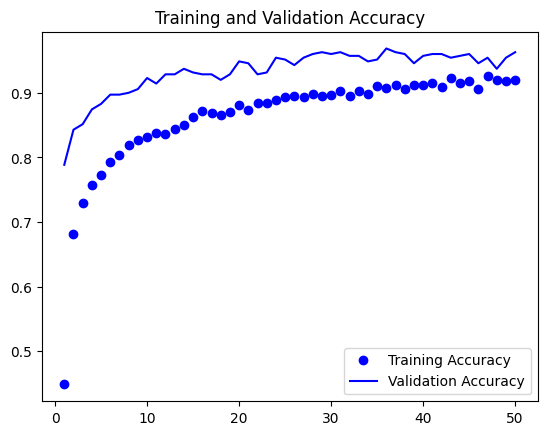

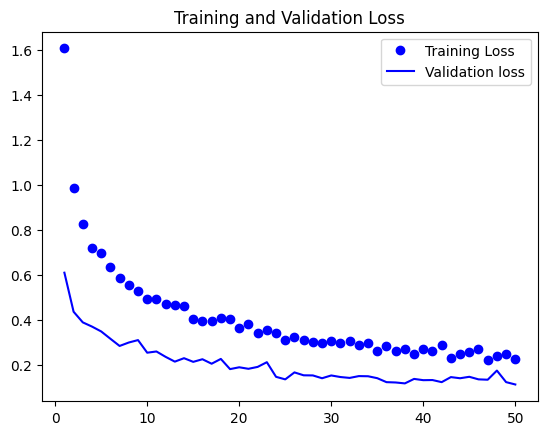

In [ ]:
acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochss = range(1, len(acc) + 1)
plt.plot(epochss, acc, "bo", label="Training Accuracy")
plt.plot(epochss, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochss, loss, "bo", label="Training Loss")
plt.plot(epochss, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
callbacks = [
              EarlyStopping(monitor=monitor, min_delta=min_delta,
                            patience=patience, restore_best_weights=True)
            ]

history2 = model2.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, shuffle=True, callbacks=callbacks)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 110s 402ms/step - accuracy: 0.4367 - loss: 2.1268 - val_accuracy: 0.8057 - val_loss: 0.6156
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 68s 342ms/step - accuracy: 0.7006 - loss: 1.1761 - val_accuracy: 0.8257 - val_loss: 0.6332
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 68s 344ms/step - accuracy: 0.7373 - loss: 1.0951 - val_accuracy: 0.8514 - val_loss: 0.5049
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 341ms/step - accuracy: 0.7749 - loss: 0.9248 - val_accuracy: 0.8457 - val_loss: 0.5537
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.7897 - loss: 0.8865 - val_accuracy: 0.8343 - val_loss: 0.7345
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 72s 367ms/step - accuracy: 0.8142 - loss: 0.8332 - val_accuracy: 0.8800 - val_loss: 0.4685
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 67s 340ms/step - accuracy: 0.8140 - loss: 0.8351 - val_accuracy: 0.8686 - val_loss: 0.5160
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 342ms/step - accuracy: 0.8048 - loss: 

In [ ]:
model2.summary()

Model: "pretrained_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nasnet_large (Functional)            │ (None, 8, 8, 4032)          │      84,916,818 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 258048)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,060,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,103,850 (1.05 GB)

 Trainable params: 66,062,343 (252.01 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

 Optimizer params: 132,124,689 (504.02 MB)

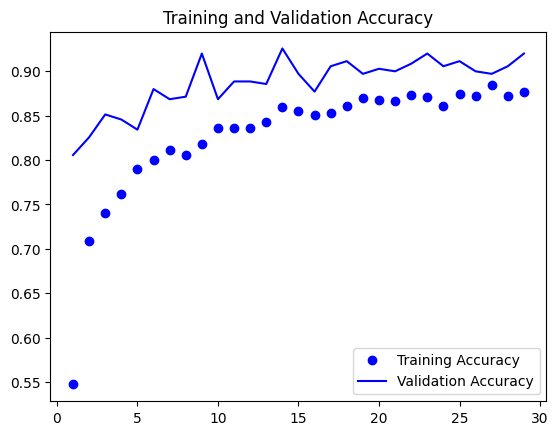

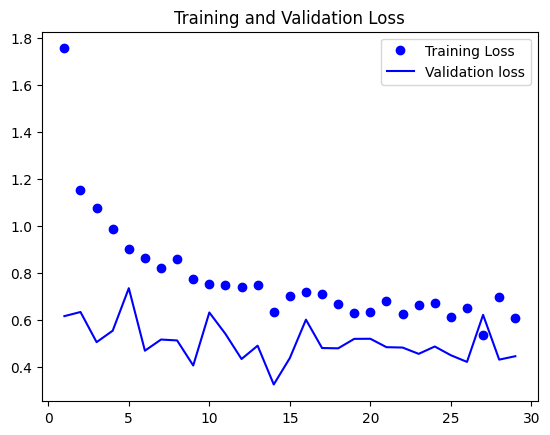

In [ ]:
acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochss = range(1, len(acc) + 1)
plt.plot(epochss, acc, "bo", label="Training Accuracy")
plt.plot(epochss, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochss, loss, "bo", label="Training Loss")
plt.plot(epochss, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# 앙상블 모델

In [ ]:
model1_loss, model1_acc = model1.evaluate(valid_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - accuracy: 0.9541 - loss: 0.1449


In [ ]:
model2_loss, model2_acc = model2.evaluate(valid_dataset)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 597ms/step - accuracy: 0.9033 - loss: 0.4650


In [ ]:
model_accs = (model1_acc, model2_acc)

In [ ]:
model_accs

(0.9628571271896362, 0.9257143139839172)

In [ ]:
proba_weights = tf.constant(model_accs) / sum(model_accs)

In [ ]:
proba_weights

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5098336, 0.4901664], dtype=float32)>

In [ ]:
image_classifier = EnsembleClassifier(model1=model1, model2=model2, proba_weights=proba_weights)

# 평가

In [ ]:
correct = 0
wrong = 0

for x, y in valid_dataset:
    n = len(y)
    answer = tf.math.reduce_sum(tf.cast(image_classifier(x) == y, dtype=tf.int32)).numpy()
    correct += answer
    wrong += (n - answer)

print(f"정답 갯수: {correct}")
print(f"오답 갯수: {wrong}")
print(f"정확도: {correct / (correct + wrong)}")

정답 갯수: 340
오답 갯수: 10
정확도: 0.9714285714285714
